In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/challenge_neural_network_fra

Mounted at /gdrive
/gdrive/My Drive/challenge_neural_network_fra


In [2]:
seed=42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import numpy as np
np.random.seed(seed)

import logging
import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision
tfk.utils.set_random_seed(42)
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import cv2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
# Import other libraries
import pandas as pd
import matplotlib as mpl
plt.rc('font', size=16)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


### Load data

In [5]:
# Carica il dataset
data = np.load('augmented_dataset.npz', allow_pickle=True)
X = data['data']
labels = data['labels']

#X = X.astype('int')

# Codifica delle etichette 'healthy' e 'unhealthy' in numeri
label_dict = {'healthy': 0, 'unhealthy': 1}
y = np.array([label_dict[label] for label in labels]) # 0 è [1,0]

# Convert labels to one-hot encoding format
#y = tfk.utils.to_categorical(y,2)

# Split data into train_val and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.10, stratify=y_val_test, shuffle=True)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Print shapes of the datasets
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# Print shapes of the datasets
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")





X_train shape: (9792, 96, 96, 3), y_train shape: (9792,)
X_val shape: (2203, 96, 96, 3), y_val shape: (2203,)
X_test shape: (245, 96, 96, 3), y_test shape: (245,)


In [ ]:
#class_weights=class_weight.compute_class_weight(class_weight='balanced', y=y_train, classes=np.unique(y_train))
#class_weight_dict = dict(enumerate(class_weights))
#print(class_weights )
#print(class_weight_dict)

[0.79243081 1.35490308]
{0: 0.79243081027009, 1: 1.354903078677309}


In [ ]:
print(np.count_nonzero(labels == 'healthy'))
print(np.count_nonzero(labels == 'unhealthy'))
print(np.count_nonzero(y_train == 0))
print(np.count_nonzero(y_train == 1))
print(np.count_nonzero(y_test == 0))
print(np.count_nonzero(y_test == 1))
print(np.count_nonzero(y_val == 0))
print(np.count_nonzero(y_val == 1))

6120
6120
4896
4896
122
123
1102
1101


In [ ]:
# Normalize data to the range [0, 1]
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")
X_test = X_test.astype("float32")

## Transfer Learning



In [ ]:
model = tf.keras.applications.ConvNeXtLarge(
    input_shape=(96,96,3),
    include_top=False,
    weights="imagenet",
    pooling='avg'
)

#tfk.utils.plot_model(efficient, show_shapes=True)

In [ ]:
# Define batch size, number of epochs, learning rate, input shape, and output shape
batch_size = 64
epochs = 1000
learning_rate = 0.001
input_shape = (X_train.shape[1:])
output_shape = y_train.shape[-1]

# Print batch size, epochs, learning rate, input shape, and output shape
print(f"Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {learning_rate}")
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}")

Batch Size: 64, Epochs: 1000, Learning Rate: 0.001
Input Shape: (96, 96, 3), Output Shape: 9792


In [ ]:
cropsize=[20,20]

In [ ]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
model.trainable = False

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))

#PREPROCESSING

preprocessing = tfk.Sequential([
        #tfkl.RandomContrast(0.4),
        #tfkl.RandomBrightness(0.4, value_range=(0,255)),
        tfkl.RandomFlip(),
        tfkl.RandomRotation(0.3, fill_mode='reflect'),
        #tfkl.RandomZoom(height_factor=(-0.2,0), fill_mode='reflect', interpolation='nearest'),

        #tfkl.ZeroPadding2D((cropsize[0], cropsize[1]), name='ZeroPadding_2x2'),
        #tfkl.RandomCrop(input_shape[0]-cropsize[0], input_shape[1]-cropsize[1], name='RandomCrop'),
        #tfkl.RandomTranslation(0.2,0.2)
        #tfkl.Resizing(input_shape[0],input_shape[1], interpolation='nearest')
        #tfkl.RandomRotation(factor=0.25),
        #tfkl.RandomTranslation(height_factor=0.1, width_factor=0.1),
        #tfkl.RandomFlip(),
        #tfkl.RandomContrast(factor=0.1),


    ], name='Preprocessing')


x0 = preprocessing(inputs)

# Connect efficientnet to the input
x1 = model(x0,training=False)


#NEW LAYER

x2 = tfkl.Dense(units=256, kernel_initializer=tfk.initializers.HeUniform(), name='HiddenDense1', activation='relu')(x1)
x2drop= tfkl.Dropout(0.5)(x2)
x3 = tfkl.Dense(units=256, kernel_initializer=tfk.initializers.HeUniform(), name='HiddenDense2', activation='relu')(x2drop)
x3drop= tfkl.Dropout(0.5)(x3)


# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(1, activation='sigmoid')(x2drop)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='ConvNextBaseforEnsemble')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate,0.004), metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()], weighted_metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "ConvNextBaseforEnsemble"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 Preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                           

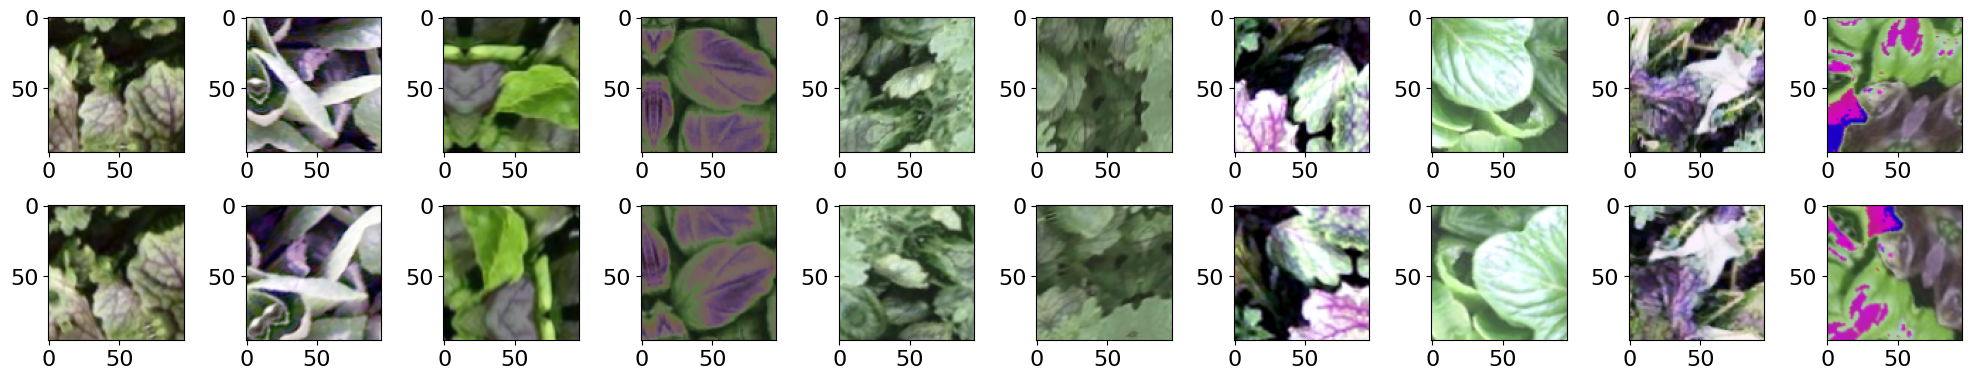

In [ ]:
X_train_processed = preprocessing(X_train)
num_img=10
X_train_processed= tf.cast(X_train_processed, 'float32')
fig, axes = plt.subplots(2, num_img, figsize=(20,4))
for i in range(num_img):
    ax = axes[0,i%num_img]
    ax.imshow(X_train[i+20]/255)
    ax = axes[1,i%num_img]
    ax.imshow(X_train_processed[i+20]/255)
plt.tight_layout()
plt.show()

In [ ]:
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',     # Metric to monitor (validation mean squared error in this case)
    patience=40,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.5,          # Factor by which the learning rate will be reduced (0.999 in this case)
    #in questo esempio abbiamo messo un fattore abbastanza grande quindi il learning rate factor non diminuirà di troppo
    mode='min',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-5            # Minimum learning rate
)

early_stopping=tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=60, restore_best_weights=True)
callbacks=[early_stopping]


# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train), # We need to apply the preprocessing thought for the network
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val), y_val), # We need to apply the preprocessing thought for the network
    callbacks = callbacks
    #class_weight=class_weight_dict

).history

Epoch 1/1000
153/153 [==============================] - 37s 163ms/step - loss: 0.5769 - accuracy: 0.7130 - precision_4: 0.7166 - recall_4: 0.7049 - weighted_accuracy: 0.7130 - val_loss: 0.4464 - val_accuracy: 0.7876 - val_precision_4: 0.8474 - val_recall_4: 0.7012 - val_weighted_accuracy: 0.7876
Epoch 2/1000
153/153 [==============================] - 15s 101ms/step - loss: 0.4621 - accuracy: 0.7807 - precision_4: 0.7786 - recall_4: 0.7845 - weighted_accuracy: 0.7807 - val_loss: 0.4454 - val_accuracy: 0.7880 - val_precision_4: 0.8476 - val_recall_4: 0.7021 - val_weighted_accuracy: 0.7880
Epoch 3/1000
153/153 [==============================] - 15s 101ms/step - loss: 0.4330 - accuracy: 0.7988 - precision_4: 0.8007 - recall_4: 0.7958 - weighted_accuracy: 0.7988 - val_loss: 0.3908 - val_accuracy: 0.8225 - val_precision_4: 0.8394 - val_recall_4: 0.7975 - val_weighted_accuracy: 0.8225
Epoch 4/1000
153/153 [==============================] - 15s 98ms/step - loss: 0.4158 - accuracy: 0.8050 - pre

In [ ]:
# Evaluate the model on the test set
test_accuracy = tl_model.evaluate(preprocess_input(X_test),y_test,verbose=0, return_dict=True)
print(test_accuracy)
# Evaluate the model on the test set
val_accuracy = tl_model.evaluate(preprocess_input(X_val),y_val,verbose=0, return_dict=True)
print(val_accuracy)
# Evaluate the model on the test set
train_accuracy = tl_model.evaluate(preprocess_input(X_train),y_train,verbose=0, return_dict=True)
print(train_accuracy)

{'loss': 0.3003401756286621, 'accuracy': 0.9102040529251099, 'precision_4': 0.9039999842643738, 'recall_4': 0.9186992049217224, 'weighted_accuracy': 0.9102040529251099}
{'loss': 0.3548930287361145, 'accuracy': 0.8937811851501465, 'precision_4': 0.8894878625869751, 'recall_4': 0.8991825580596924, 'weighted_accuracy': 0.8937811851501465}
{'loss': 0.07849420607089996, 'accuracy': 0.9720180034637451, 'precision_4': 0.9725971221923828, 'recall_4': 0.9714052081108093, 'weighted_accuracy': 0.9720180034637451}


In [ ]:
y_prediction = tl_model.predict(X_test)
print(y_test.shape)
#y_prediction_bin = np.argmax (y_prediction, axis = -1)
#y_test_bin=np.argmax(y_test, axis=-1)
y_prediction_bin= ((y_prediction > 0.5)+0).ravel()
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction_bin)
print(result)

8/8 [==============================] - 4s 62ms/step
(245,)
[[110  12]
 [ 10 113]]


In [ ]:
# Save the best model
tl_model.save('augmentedDatasetConvnextLarge')


In [ ]:
#del tl_model

In [30]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('augmentedDatasetConvnextLarge')
#ft_model = tl_model
ft_model.summary()

Model: "ConvNextBaseforEnsemble"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 Preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                           

In [31]:
# Set all layers as trainable
ft_model.get_layer('convnext_large').trainable = True
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)

0 input_5 True
1 convnext_large_prestem_normalization True
2 convnext_large_stem True
3 convnext_large_stage_0_block_0_depthwise_conv True
4 convnext_large_stage_0_block_0_layernorm True
5 convnext_large_stage_0_block_0_pointwise_conv_1 True
6 convnext_large_stage_0_block_0_gelu True
7 convnext_large_stage_0_block_0_pointwise_conv_2 True
8 convnext_large_stage_0_block_0_layer_scale True
9 convnext_large_stage_0_block_0_identity True
10 tf.__operators__.add_72 True
11 convnext_large_stage_0_block_1_depthwise_conv True
12 convnext_large_stage_0_block_1_layernorm True
13 convnext_large_stage_0_block_1_pointwise_conv_1 True
14 convnext_large_stage_0_block_1_gelu True
15 convnext_large_stage_0_block_1_pointwise_conv_2 True
16 convnext_large_stage_0_block_1_layer_scale True
17 convnext_large_stage_0_block_1_identity True
18 tf.__operators__.add_73 True
19 convnext_large_stage_0_block_2_depthwise_conv True
20 convnext_large_stage_0_block_2_layernorm True
21 convnext_large_stage_0_block_2_poin

In [32]:
# Freeze first N layers, e.g., until the 133rd one
N = 285
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('convnext_large').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_5 False
1 convnext_large_prestem_normalization False
2 convnext_large_stem False
3 convnext_large_stage_0_block_0_depthwise_conv False
4 convnext_large_stage_0_block_0_layernorm False
5 convnext_large_stage_0_block_0_pointwise_conv_1 False
6 convnext_large_stage_0_block_0_gelu False
7 convnext_large_stage_0_block_0_pointwise_conv_2 False
8 convnext_large_stage_0_block_0_layer_scale False
9 convnext_large_stage_0_block_0_identity False
10 tf.__operators__.add_72 False
11 convnext_large_stage_0_block_1_depthwise_conv False
12 convnext_large_stage_0_block_1_layernorm False
13 convnext_large_stage_0_block_1_pointwise_conv_1 False
14 convnext_large_stage_0_block_1_gelu False
15 convnext_large_stage_0_block_1_pointwise_conv_2 False
16 convnext_large_stage_0_block_1_layer_scale False
17 convnext_large_stage_0_block_1_identity False
18 tf.__operators__.add_73 False
19 convnext_large_stage_0_block_2_depthwise_conv False
20 convnext_large_stage_0_block_2_layernorm False
21 convnext_large

In [33]:
# Compile the model
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(0.001, weight_decay=0.004), metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()], weighted_metrics='accuracy')

In [34]:
# Fine-tune the model
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',     # Metric to monitor (validation mean squared error in this case)
    patience=50,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.5,          # Factor by which the learning rate will be reduced (0.999 in this case)
    #in questo esempio abbiamo messo un fattore abbastanza grande quindi il learning rate factor non diminuirà di troppo
    mode='min',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=0           # Minimum learning rate
)

early_stopping=tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=70, restore_best_weights=True)
callbacks=[lr_scheduler,early_stopping]

ft_history = ft_model.fit(
    x = preprocess_input(X_train), # We need to apply the preprocessing thought for the efficientnet network
    y = y_train,
    batch_size = 64,
    epochs = 1000,
    validation_data = (preprocess_input(X_val), y_val), # We need to apply the preprocessing thought for the efficientnet network
    callbacks = callbacks
    #class_weight=class_weight_dict
).history

Epoch 1/1000
153/153 [==============================] - 40s 167ms/step - loss: 0.1494 - accuracy: 0.9424 - precision_4: 0.9411 - recall_4: 0.9438 - weighted_accuracy: 0.9424 - val_loss: 0.4151 - val_accuracy: 0.8756 - val_precision_4: 0.9034 - val_recall_4: 0.8411 - val_weighted_accuracy: 0.8756 - lr: 0.0010
Epoch 2/1000
153/153 [==============================] - 16s 105ms/step - loss: 0.1174 - accuracy: 0.9550 - precision_4: 0.9538 - recall_4: 0.9563 - weighted_accuracy: 0.9550 - val_loss: 0.3779 - val_accuracy: 0.8838 - val_precision_4: 0.8908 - val_recall_4: 0.8747 - val_weighted_accuracy: 0.8838 - lr: 0.0010
Epoch 3/1000
153/153 [==============================] - 16s 102ms/step - loss: 0.1180 - accuracy: 0.9557 - precision_4: 0.9557 - recall_4: 0.9557 - weighted_accuracy: 0.9557 - val_loss: 0.4183 - val_accuracy: 0.8774 - val_precision_4: 0.9078 - val_recall_4: 0.8401 - val_weighted_accuracy: 0.8774 - lr: 0.0010
Epoch 4/1000
153/153 [==============================] - 16s 102ms/step

In [2]:
import numpy as np

In [3]:


# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

NameError: ignored

In [35]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test),y_test,verbose=0, return_dict=True)
print(test_accuracy)
# Evaluate the model on the test set
val_accuracy = ft_model.evaluate(preprocess_input(X_val),y_val,verbose=0, return_dict=True)
print(val_accuracy)
# Evaluate the model on the test set
train_accuracy = ft_model.evaluate(preprocess_input(X_train),y_train,verbose=0, return_dict=True)
print(train_accuracy)

{'loss': 0.255479633808136, 'accuracy': 0.9306122660636902, 'precision_4': 0.9274193644523621, 'recall_4': 0.934959352016449, 'weighted_accuracy': 0.9306122660636902}
{'loss': 0.38914841413497925, 'accuracy': 0.8978665471076965, 'precision_4': 0.9025735259056091, 'recall_4': 0.8919164538383484, 'weighted_accuracy': 0.8978665471076965}
{'loss': 0.04677925631403923, 'accuracy': 0.9844771027565002, 'precision_4': 0.9868637323379517, 'recall_4': 0.9820261597633362, 'weighted_accuracy': 0.9844771027565002}


In [36]:
y_prediction = ft_model.predict(X_test)
print(y_test.shape)
#y_prediction_bin = np.argmax (y_prediction, axis = -1)
#y_test_bin=np.argmax(y_test, axis=-1)
y_prediction_bin= ((y_prediction > 0.5)+0).ravel()
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction_bin)
print(result)
print(y_prediction)

8/8 [==============================] - 4s 64ms/step
(245,)
[[113   9]
 [  8 115]]
[[2.41742182e-08]
 [2.59593651e-02]
 [6.28877103e-07]
 [8.88364255e-01]
 [9.98619199e-01]
 [8.25268924e-02]
 [3.37214246e-02]
 [1.21135596e-18]
 [9.99552190e-01]
 [2.38174904e-13]
 [1.00000000e+00]
 [9.99489427e-01]
 [5.42323112e-01]
 [9.99998331e-01]
 [3.41979586e-07]
 [7.04169281e-07]
 [9.15950298e-01]
 [1.00000000e+00]
 [8.58509660e-01]
 [1.00000000e+00]
 [9.99664664e-01]
 [9.99991059e-01]
 [5.32214865e-02]
 [9.53134179e-01]
 [6.65051942e-08]
 [1.00000000e+00]
 [9.36527848e-01]
 [9.98511612e-01]
 [9.99625444e-01]
 [5.17063558e-01]
 [2.21871495e-01]
 [2.14625274e-07]
 [3.11582182e-09]
 [9.99998808e-01]
 [1.87897563e-01]
 [1.51149870e-05]
 [4.36540595e-11]
 [7.84235017e-04]
 [7.98119891e-06]
 [1.70701124e-08]
 [2.22788565e-02]
 [9.99999762e-01]
 [3.86674474e-05]
 [7.89746719e-06]
 [2.39742862e-04]
 [7.51741780e-09]
 [7.92456448e-01]
 [9.29467774e-07]
 [2.01872140e-02]
 [9.99997973e-01]
 [7.68572325e-04]


In [37]:
# Save the best model
ft_model.save('augmentedDatasetConvnextLargeFTMax')

In [ ]:
ft_model.save('augmentedDatasetConvnextLargeFTT')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-4b31735c5817>", line 1, in <cell line: 1>
    ft_model.save('augmentedDatasetConvnextLargeFTT')
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/lib/io/file_io.py", line 513, in recursive_create_dir_v2
    _pywrap_file_io.RecursivelyCreateDir(compat.path_to_bytes(path))
tensorflow.python.framework.errors_impl.FailedPreconditionError: augmentedDatasetConvnextLargeFTT; Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 20

In [ ]:
new_model=ft_model

In [ ]:
new_model.save('augmentedDatasetConvnextLargeFTTT')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-40-47426cfb2a3f>", line 1, in <cell line: 1>
    new_model.save('augmentedDatasetConvnextLargeFTTT')
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/lib/io/file_io.py", line 513, in recursive_create_dir_v2
    _pywrap_file_io.RecursivelyCreateDir(compat.path_to_bytes(path))
tensorflow.python.framework.errors_impl.FailedPreconditionError: augmentedDatasetConvnextLargeFTTT; Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line

In [ ]:
ft_model.get_layer('augmentedDatasetConvnextLarge').trainable = False